# Data Integrity & Completeness Checks

This notebook performs **data quality validation** for both data sources used in the EDA:

1. **Coin Metrics BTC on-chain data** (`coinmetrics_btc.csv`), used in Parts 1 & 2
2. **Polymarket prediction market data** (6 parquet files), used in Part 3

**Checks performed:**
- Data types and schema validation
- Value ranges and domain constraints
- Missingness and completeness per column
- Duplicate detection
- Summary statistics for key numeric columns

## 1. Setup

In [ ]:
from __future__ import annotations

from pathlib import Path

import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

# --- Paths ---
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "eda" else NOTEBOOK_DIR
DATA_DIR = PROJECT_ROOT / "data"
COINMETRICS_PATH = DATA_DIR / "Coin Metrics" / "coinmetrics_btc.csv"
POLYMARKET_DIR = DATA_DIR / "Polymarket"

PARQUET_FILES = {
    "markets": "finance_politics_markets.parquet",
    "tokens": "finance_politics_tokens.parquet",
    "odds_history": "finance_politics_odds_history.parquet",
    "trades": "finance_politics_trades.parquet",
    "event_stats": "finance_politics_event_stats.parquet",
    "summary": "finance_politics_summary.parquet",
}

print(f"Project root     : {PROJECT_ROOT}")
print(f"Coin Metrics CSV : {COINMETRICS_PATH}  (exists: {COINMETRICS_PATH.exists()})")
print(f"Polymarket dir   : {POLYMARKET_DIR}  (exists: {POLYMARKET_DIR.exists()})")

Project root     : c:\Users\tsivakumar\Projects\OMSA
Coin Metrics CSV : c:\Users\tsivakumar\Projects\OMSA\data\Coin Metrics\coinmetrics_btc.csv  (exists: True)
Polymarket dir   : c:\Users\tsivakumar\Projects\OMSA\data\Polymarket  (exists: True)


---

# Section A: Coin Metrics BTC Data

## 2. Load & Inspect Schema

In [ ]:
# Load full CSV
cm_raw = pl.read_csv(str(COINMETRICS_PATH), infer_schema_length=10000)

print(f"Shape: {cm_raw.shape[0]:,} rows × {cm_raw.shape[1]} columns")
print(f"\n--- Column Data Types ---")
schema_df = pl.DataFrame({
    "column": list(cm_raw.schema.keys()),
    "dtype": [str(v) for v in cm_raw.schema.values()],
})
print(schema_df)

Shape: 6,221 rows × 32 columns

--- Column Data Types ---
shape: (32, 2)
┌─────────────────────────────┬─────────┐
│ column                      ┆ dtype   │
│ ---                         ┆ ---     │
│ str                         ┆ str     │
╞═════════════════════════════╪═════════╡
│ time                        ┆ String  │
│ AdrActCnt                   ┆ Int64   │
│ AdrBalCnt                   ┆ Int64   │
│ AssetCompletionTime         ┆ Int64   │
│ AssetEODCompletionTime      ┆ Int64   │
│ …                           ┆ …       │
│ SplyExUSD                   ┆ Float64 │
│ SplyExpFut10yr              ┆ Float64 │
│ TxCnt                       ┆ Int64   │
│ TxTfrCnt                    ┆ Int64   │
│ volume_reported_spot_usd_1d ┆ Float64 │
└─────────────────────────────┴─────────┘


## 3. Check for Date Gaps

In [ ]:
# Parse the time column
cm = cm_raw.with_columns(
    pl.col("time").str.strptime(pl.Date, "%Y-%m-%d").alias("date")
).sort("date")

date_min = cm["date"].min()
date_max = cm["date"].max()
n_rows = len(cm)

print(f"Date range: {date_min} → {date_max}")
print(f"Total rows: {n_rows:,}")
print(f"Expected calendar days: {(date_max - date_min).days + 1:,}")
print(f"Actual rows vs expected: {n_rows} / {(date_max - date_min).days + 1}")

# Check for date gaps
date_series = cm["date"].to_list()
expected_dates = set(pl.date_range(date_min, date_max, eager=True).to_list())
actual_dates = set(date_series)
missing_dates = sorted(expected_dates - actual_dates)

if missing_dates:
    print(f"\n⚠️  MISSING DATES: {len(missing_dates)} gaps found")
    for d in missing_dates[:20]:
        print(f"   {d}")
    if len(missing_dates) > 20:
        print(f"   ... and {len(missing_dates) - 20} more")
else:
    print("\n✅ No date gaps — continuous daily coverage")

Date range: 2009-01-03 → 2026-01-14
Total rows: 6,221
Expected calendar days: 6,221
Actual rows vs expected: 6221 / 6221

✅ No date gaps — continuous daily coverage


## 4. Duplicate Detection

In [ ]:
# Check for duplicate dates
dup_dates = cm.group_by("date").len().filter(pl.col("len") > 1)

if len(dup_dates) > 0:
    print(f"⚠️  DUPLICATE DATES: {len(dup_dates)} dates have multiple rows")
    print(dup_dates.head(10))
else:
    print("✅ No duplicate dates — each date appears exactly once")

# Check for fully duplicated rows
n_exact_dupes = n_rows - cm.unique().shape[0]
print(f"\nExact duplicate rows: {n_exact_dupes}")

✅ No duplicate dates — each date appears exactly once

Exact duplicate rows: 0


## 5. Missingness & Completeness

In [ ]:
# Null counts per column
null_counts = cm.null_count()

# Build a summary DataFrame
completeness = pl.DataFrame({
    "column": list(null_counts.columns),
    "null_count": [null_counts[c][0] for c in null_counts.columns],
    "total_rows": [n_rows] * len(null_counts.columns),
}).with_columns(
    (pl.col("null_count") / pl.col("total_rows") * 100).round(2).alias("pct_missing"),
    (100 - pl.col("null_count") / pl.col("total_rows") * 100).round(2).alias("pct_complete"),
).sort("pct_missing", descending=True)

print("--- Missingness Summary (sorted by % missing, descending) ---")
print(f"\nColumns with 100% completeness: {completeness.filter(pl.col('null_count') == 0).shape[0]} / {completeness.shape[0]}")
print(f"Columns with any missing data:  {completeness.filter(pl.col('null_count') > 0).shape[0]}")

# Show only columns with missing data
missing_cols = completeness.filter(pl.col("null_count") > 0)
if len(missing_cols) > 0:
    print(f"\n--- Columns with Missing Values ---")
    print(missing_cols)
else:
    print("\n✅ No missing values in any column")

--- Missingness Summary (sorted by % missing, descending) ---

Columns with 100% completeness: 2 / 33
Columns with any missing data:  31

--- Columns with Missing Values ---
shape: (31, 5)
┌──────────────────┬────────────┬────────────┬─────────────┬──────────────┐
│ column           ┆ null_count ┆ total_rows ┆ pct_missing ┆ pct_complete │
│ ---              ┆ ---        ┆ ---        ┆ ---         ┆ ---          │
│ str              ┆ i64        ┆ i64        ┆ f64         ┆ f64          │
╞══════════════════╪════════════╪════════════╪═════════════╪══════════════╡
│ ReferenceRate    ┆ 6214       ┆ 6221       ┆ 99.89       ┆ 0.11         │
│ ReferenceRateETH ┆ 6214       ┆ 6221       ┆ 99.89       ┆ 0.11         │
│ ReferenceRateEUR ┆ 6214       ┆ 6221       ┆ 99.89       ┆ 0.11         │
│ ReferenceRateUSD ┆ 6214       ┆ 6221       ┆ 99.89       ┆ 0.11         │
│ CapMrktEstUSD    ┆ 3823       ┆ 6221       ┆ 61.45       ┆ 38.55        │
│ …                ┆ …          ┆ …          ┆ …   

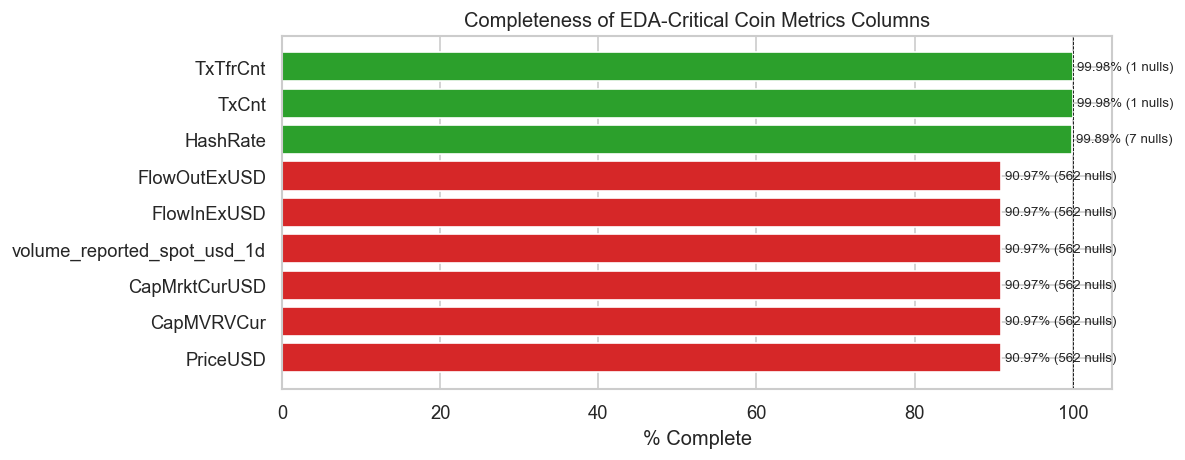

In [ ]:
# Visualize missingness for columns used in the EDA
eda_columns = [
    "PriceUSD", "CapMVRVCur", "CapMrktCurUSD",
    "volume_reported_spot_usd_1d", "TxCnt", "TxTfrCnt",
    "FlowInExUSD", "FlowOutExUSD", "HashRate",
    "NVTAdj", "NVTAdj90",
]
# Filter to columns that actually exist
eda_columns = [c for c in eda_columns if c in cm.columns]

eda_nulls = []
for col in eda_columns:
    nc = cm[col].null_count()
    eda_nulls.append({
        "column": col,
        "null_count": nc,
        "pct_complete": round((1 - nc / n_rows) * 100, 2),
    })

eda_null_df = pl.DataFrame(eda_nulls).sort("pct_complete")

fig, ax = plt.subplots(figsize=(10, 4))
colors = ["#d62728" if v < 95 else "#ff7f0e" if v < 99 else "#2ca02c" for v in eda_null_df["pct_complete"].to_list()]
ax.barh(eda_null_df["column"].to_list(), eda_null_df["pct_complete"].to_list(), color=colors)
ax.set_xlim(0, 105)
ax.axvline(100, color="black", linewidth=0.5, linestyle="--")
ax.set_xlabel("% Complete")
ax.set_title("Completeness of EDA-Critical Coin Metrics Columns")
for i, (v, n) in enumerate(zip(eda_null_df["pct_complete"].to_list(), eda_null_df["null_count"].to_list())):
    ax.text(v + 0.5, i, f"{v}% ({n} nulls)", va="center", fontsize=8)
plt.tight_layout()
plt.show()

## 6. Value Ranges & Domain Constraints

In [ ]:
# Key columns: check min, max, mean, std for reasonableness
range_cols = [c for c in eda_columns if cm[c].dtype in (pl.Float64, pl.Int64, pl.Float32, pl.Int32)]

range_checks = []
for col in range_cols:
    s = cm[col].drop_nulls()
    range_checks.append({
        "column": col,
        "dtype": str(cm[col].dtype),
        "count": len(s),
        "min": round(s.min(), 6) if len(s) > 0 else None,
        "max": round(s.max(), 2) if len(s) > 0 else None,
        "mean": round(s.mean(), 4) if len(s) > 0 else None,
        "std": round(s.std(), 4) if len(s) > 0 else None,
        "zeros": (s == 0).sum(),
        "negatives": (s < 0).sum(),
    })

range_df = pl.DataFrame(range_checks)
print("--- Value Ranges for EDA-Critical Columns ---")
print(range_df)

# Flag specific domain violations
print("\n--- Domain Constraint Checks ---")
for col in ["PriceUSD", "CapMVRVCur", "CapMrktCurUSD", "HashRate"]:
    if col in cm.columns:
        neg = cm.filter(pl.col(col) < 0).shape[0]
        zero = cm.filter(pl.col(col) == 0).shape[0]
        symbol = "✅" if neg == 0 and zero == 0 else "⚠️"
        print(f"  {symbol} {col}: {neg} negative, {zero} zero values")

--- Value Ranges for EDA-Critical Columns ---
shape: (9, 9)
┌──────────────┬─────────┬───────┬─────────────┬───┬─────────────┬─────────────┬───────┬───────────┐
│ column       ┆ dtype   ┆ count ┆ min         ┆ … ┆ mean        ┆ std         ┆ zeros ┆ negatives │
│ ---          ┆ ---     ┆ ---   ┆ ---         ┆   ┆ ---         ┆ ---         ┆ ---   ┆ ---       │
│ str          ┆ str     ┆ i64   ┆ f64         ┆   ┆ f64         ┆ f64         ┆ i64   ┆ i64       │
╞══════════════╪═════════╪═══════╪═════════════╪═══╪═════════════╪═════════════╪═══════╪═══════════╡
│ PriceUSD     ┆ Float64 ┆ 5659  ┆ 0.050541    ┆ … ┆ 19809.9878  ┆ 29699.0787  ┆ 0     ┆ 0         │
│ CapMVRVCur   ┆ Float64 ┆ 5659  ┆ 0.386829    ┆ … ┆ 1.9898      ┆ 2.4939      ┆ 0     ┆ 0         │
│ CapMrktCurUS ┆ Float64 ┆ 5659  ┆ 177670.4897 ┆ … ┆ 3.8264e11   ┆ 5.8737e11   ┆ 0     ┆ 0         │
│ D            ┆         ┆       ┆ 54          ┆   ┆             ┆             ┆       ┆           │
│ volume_repor ┆ Float64 ┆ 5659

## 7. Descriptive Statistics for Key Columns

In [ ]:
# Full descriptive stats for EDA-critical columns
desc = cm.select(eda_columns).describe()
print("--- Descriptive Statistics (EDA Columns) ---")
desc

--- Descriptive Statistics (EDA Columns) ---


statistic,PriceUSD,CapMVRVCur,CapMrktCurUSD,volume_reported_spot_usd_1d,TxCnt,TxTfrCnt,FlowInExUSD,FlowOutExUSD,HashRate
str,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",5659.0,5659.0,5659.0,5659.0,6220.0,6220.0,5659.0,5659.0,6214.0
"""null_count""",562.0,562.0,562.0,562.0,1.0,1.0,562.0,562.0,7.0
"""mean""",19809.987841,1.989795,3.8264e11,5.1167e9,208414.228457,497111.757717,5.0364e8,5.5848e8,1.5146e8
"""std""",29699.078673,2.493876,5.8737e11,7.5850e9,170293.817001,373305.629144,8.1787e8,9.5674e8,2.6345e8
"""min""",0.050541,0.386829,177670.489754,0.0,0.0,0.0,0.0,0.0,1.9884e-7
"""25%""",260.651331,1.294308,3.6730e9,1.0577e7,47182.0,104349.0,8.8193e6,8.5762e6,62.554011
"""50%""",5728.351702,1.754254,9.7931e10,1.3492e9,224435.0,557988.0,1.4120e8,1.4169e8,5.5673e6
"""75%""",28844.613678,2.256992,5.5492e11,8.1901e9,312571.0,798101.0,6.5356e8,6.9312e8,1.6529e8
"""max""",124824.453667,146.038332,2.4879e12,7.4786e10,928131.0,2.041653e6,7.2940e9,8.1840e9,1.3055e9


---

# Section B: Polymarket Data

## 8. Load All Parquet Files & Inspect Schemas

In [ ]:
poly = {}
for name, filename in PARQUET_FILES.items():
    path = POLYMARKET_DIR / filename
    if path.exists():
        df = pl.read_parquet(str(path))
        poly[name] = df
        print(f"\n{'='*60}")
        print(f"{name}: {df.shape[0]:,} rows × {df.shape[1]} cols")
        print(f"Columns & types:")
        for col_name, col_type in df.schema.items():
            print(f"  {col_name:30s} {str(col_type)}")
    else:
        print(f"⚠️  {name}: file not found at {path}")


markets: 78,321 rows × 10 cols
Columns & types:
  market_id                      String
  question                       String
  slug                           String
  event_slug                     String
  category                       String
  volume                         Float64
  active                         Boolean
  closed                         Boolean
  created_at                     Datetime(time_unit='us', time_zone=None)
  end_date                       Datetime(time_unit='us', time_zone=None)

tokens: 156,636 rows × 3 cols
Columns & types:
  market_id                      String
  token_id                       String
  outcome                        String

odds_history: 2,143,181 rows × 4 cols
Columns & types:
  market_id                      String
  token_id                       String
  timestamp                      Datetime(time_unit='us', time_zone=None)
  price                          Float64

trades: 27,013,724 rows × 9 cols
Columns & types:
  trade_id

## 9. Polymarket — Missingness & Completeness

In [ ]:
for name, df in poly.items():
    print(f"\n{'='*60}")
    print(f"{name} — Missingness Summary")
    print(f"{'='*60}")
    nc = df.null_count()
    total = len(df)
    has_missing = False
    for col_name in nc.columns:
        n_null = nc[col_name][0]
        if n_null > 0:
            has_missing = True
            pct = round(n_null / total * 100, 2)
            print(f"  ⚠️  {col_name}: {n_null:,} nulls ({pct}%)")
    if not has_missing:
        print(f"  ✅ No missing values (all {total:,} rows complete)")


markets — Missingness Summary
  ⚠️  end_date: 535 nulls (0.68%)

tokens — Missingness Summary
  ✅ No missing values (all 156,636 rows complete)

odds_history — Missingness Summary
  ✅ No missing values (all 2,143,181 rows complete)

trades — Missingness Summary
  ⚠️  maker_address: 13,041 nulls (0.05%)
  ⚠️  taker_address: 21,827 nulls (0.08%)

event_stats — Missingness Summary
  ⚠️  last_market_end: 147 nulls (0.33%)

summary — Missingness Summary
  ⚠️  first_trade: 42,152 nulls (53.82%)
  ⚠️  last_trade: 42,152 nulls (53.82%)


## 10. Polymarket — Duplicate Detection

In [ ]:
# Define primary keys for each table
pk_map = {
    "markets": ["market_id"],
    "tokens": ["token_id"],
    "odds_history": ["token_id", "timestamp"],
    "trades": ["trade_id"],
    "event_stats": ["event_slug"],
    "summary": ["market_id"],
}

for name, df in poly.items():
    pk = pk_map.get(name)
    if pk is None:
        continue
    # Check if all PK columns exist
    existing_pk = [c for c in pk if c in df.columns]
    if len(existing_pk) != len(pk):
        print(f"⚠️  {name}: PK columns {pk} not all present (have {existing_pk})")
        continue

    n_total = len(df)
    n_unique = df.select(existing_pk).unique().shape[0]
    n_dupes = n_total - n_unique
    symbol = "✅" if n_dupes == 0 else "⚠️"
    print(f"{symbol} {name} (PK: {existing_pk}): {n_total:,} rows, {n_unique:,} unique → {n_dupes:,} duplicates")

✅ markets (PK: ['market_id']): 78,321 rows, 78,321 unique → 0 duplicates
✅ tokens (PK: ['token_id']): 156,636 rows, 156,636 unique → 0 duplicates
✅ odds_history (PK: ['token_id', 'timestamp']): 2,143,181 rows, 2,143,181 unique → 0 duplicates
✅ trades (PK: ['trade_id']): 27,013,724 rows, 27,013,724 unique → 0 duplicates
✅ event_stats (PK: ['event_slug']): 44,033 rows, 44,033 unique → 0 duplicates
✅ summary (PK: ['market_id']): 78,321 rows, 78,321 unique → 0 duplicates


## 11. Polymarket — Date Coverage

In [ ]:
# Timestamp ranges for time-series tables
# NOTE: odds_history and trades timestamps appear to be Unix MILLISECONDS
# stored under a microsecond schema (1970-01-20 dates are a giveaway).
# Fix: multiply underlying int by 1000 to get true microseconds.

def fix_ts(df: pl.DataFrame, col: str = "timestamp") -> pl.DataFrame:
    """Convert ms-epoch stored as us-epoch back to real datetimes."""
    if col not in df.columns:
        return df
    raw_min = df[col].min()
    # Only fix if dates are clearly epoch-shifted (before year 2000)
    if raw_min is not None and raw_min.year < 2000:
        df = df.with_columns(
            pl.col(col).cast(pl.Int64).mul(1000).cast(pl.Datetime("us")).alias(col)
        )
    return df

# Apply fix to time-series tables
for name in ["odds_history", "trades"]:
    if name in poly:
        poly[name] = fix_ts(poly[name], "timestamp")

print("--- Date Coverage (after timestamp correction) ---\n")

for name, ts_col in [("odds_history", "timestamp"), ("trades", "timestamp")]:
    if name in poly and ts_col in poly[name].columns:
        df = poly[name]
        ts_min = df[ts_col].min()
        ts_max = df[ts_col].max()
        print(f"{name} ({ts_col}):")
        print(f"  Range: {ts_min} -> {ts_max}")
        print(f"  Rows:  {len(df):,}")
        print()

if "markets" in poly and "created_at" in poly["markets"].columns:
    m = poly["markets"]
    print(f"markets (created_at):")
    print(f"  Earliest creation: {m['created_at'].min()}")
    print(f"  Latest creation:   {m['created_at'].max()}")
    print(f"  Total markets:     {len(m):,}")

--- Date Coverage (after timestamp correction) ---

odds_history (timestamp):
  Range: 2023-01-24 00:00:12 -> 2026-01-05 01:02:10
  Rows:  2,143,181

trades (timestamp):
  Range: 2025-04-07 08:05:19 -> 2026-01-05 06:33:19
  Rows:  27,013,724

markets (created_at):
  Earliest creation: 2020-10-02 16:10:01
  Latest creation:   2025-12-10 05:32:21
  Total markets:     78,321
